## Methods in Linear Regression

In this lab we will canvas various techniques in linear regression analysis and apply them to the numerical variable in the Ames dataset. Some of the techniques, like Ridge Regression and Lasso Regression are already implemented in sci-kit learn, or statsmodels.api but some, like best subset regression, are not. 

In this lab, we'll be looking at __Multilinear regression__, __Best Subset Selection__, __Forward Subset regression__, __Ridge Regression__ and __Lasso Regression__. We will be comparing these models using the number of degrees of freedom. We will be benchmarking these techniques using cross validation, that is by splitting our data into a training set and a test set and comparing the score on the test set. 

#### Getting back to where we were

Lets quickly download the Ames dataset and throw out the outliers recommended in the documentation. Recall

<div class="alert alert-block alert-info">
SPECIAL NOTES:<br>
There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.<br><br>

http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
</div>

Lets load in our standard libraries and dataset:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

ames = pd.read_csv('https://raw.githubusercontent.com/hjhuney/Data/master/AmesHousing/train.csv')
ames.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Our first job is to clean the outlier mentioned in the documentation for the Ames dataset. We will follow their suggestion and remove all houses over 4000 square feet of above ground living area.

In [6]:
z = ames["GrLivArea"]+ames["BsmtUnfSF"]<4000
print("Number of records removed",len(ames)-(sum(z)))
data = ames[z]

Number of records removed 24


Indeed, we can check quickly and see that this removes our weird outliers from before.

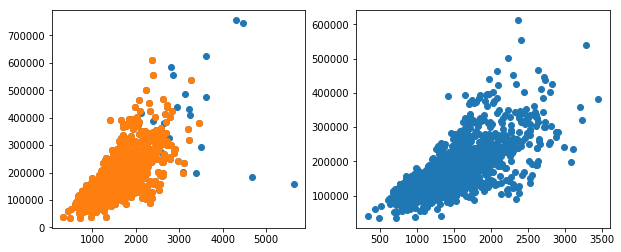

In [11]:
f, axes = plt.subplots(1,2)

f.set_size_inches(10,4)

axes[0].plot(ames['GrLivArea'],ames['SalePrice'],'o')
axes[0].plot(data['GrLivArea'],data['SalePrice'],'o')
axes[1].plot(data['GrLivArea'],data['SalePrice'],'o')

#### Removing categorical  variables

The next step is to cut out all of the categorical variables. There are ways to use regression to fit categorical variables but we will not be focusing on those methods in this lab. As before we will do this using the `DataFrame.include` function and only including the numerical data types `int64` and `float64`.

In [12]:
data = data.select_dtypes(include=['int64','float64'])
display(data.head(5))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


It is worth going through the documentation and checking if any of the variables are numeric according to python actually represent categorical variable (like error codes, phone number prefixes, etc).  In fact, we the documentation tells us that __MSSubClass__ is a categorical variable, with each number representing a zoning code. We should drop it using `DataFrame.drop()`.

* `DataFrame.drop(columns=[,])` drops a column by name, or a list of columns of by name. It then returns the new dataframe which must be saved into a variable. `drop` can also be used to drop rows. 

In addition, __ID__ is just a label and could be dropped. It should be noted that the ML school of though would actually caution against us dropping these indices. The idea is very much "throw in all the data, maybe there's some correlation there we don't see." We will drop the data for this lab just for practice.  

In [15]:
#data = data.drop(columns='MSSubClass')
data.head(5)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## Cross validation

We will now split our data into a training set and a test set. This can be done by hand, but there are also many libraries to perform the split for you. Finally, you could of course write your own function if there's a preferred  way you would like the split done.

We will first do it manually, using the `DataFrame.sample` function to pull out 100 random indices.

* `DataFrame.sample(n=None, frac=None, replace=True, random_state=None)` Sample elements of the dataframe, if `n` is specified it returns a number of elements from the dataframe, if `frac` is specified it returns a fraction of the dataframe. The `replace` determines whether the sampling is done with or without replacement. It can be set to `False` but defaults to `True`. The `random_state` parameter is a random seed.  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

In [124]:
Train_size = 1000
train = data.sample(n=Train_size, replace=False,random_state=200)
test = data.drop(train.index)

print(train.shape)
print(test.shape)
train.index

(1000, 37)
(436, 37)


Int64Index([ 788, 1402, 1429,  547,  999,  699,  869,  703,   59,  533,
            ...
            1150,  127,  354,  718,  849, 1373, 1220, 1082,  889,  155],
           dtype='int64', length=1000)

We then split the train and test into input and target data.

In [25]:
X_train = train.drop(columns=["SalePrice"])
Y_train = train["SalePrice"]

X_test = test.drop(columns=["SalePrice"])
Y_test = test["SalePrice"]

X_train.head(5)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
81,82,32.0,4500,6,5,1998,1998,443.0,1201,0,...,405,0,199,0,0,0,0,0,3,2006
1330,1331,85.0,10000,8,5,2006,2006,410.0,0,0,...,825,144,45,0,0,0,0,0,12,2007
943,944,100.0,25000,5,4,1967,1967,0.0,0,0,...,576,0,0,0,0,0,0,0,6,2007
1268,1269,NaN,14100,8,9,1935,1997,632.0,192,0,...,1014,314,12,0,0,0,0,0,5,2008
184,185,92.0,7438,5,8,1908,1991,0.0,0,0,...,576,104,0,0,0,0,0,0,6,2006


## Linear Regression

We now want to perform our first predictions using linear regression. We will do a quick one variable fit both using linear algebra and then using the sci-kit learn library and compare the fits. 

For a single feature, we want to fit a 2 vector of constants $[\beta_0,\beta_1]$ to 
$$
Y = \beta_0 + X\beta_1 = {X}^T\beta = [1,X] \left[ \begin{matrix} \beta_0\\\beta_1 \end{matrix} \right] \,.
$$
The solution will be given by
$$
\beta = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}\,,
$$
where $\mathbf{X}$ is the vector where each column is $[1,x_i]$ contains the $x_i$'s measured feature and $\mathbf{y}$ is a vector of target values.

We will convert the dataframes __X_train__ and __Y_train__ to an `numpy` matrices __X__ and __y__ respectively to perform this calculation, but lets start with one variable. We will try to fit __1stFlrSF__ to __SalePrice __.

X Shape (1, 1000)
Y Shape (1, 1000)


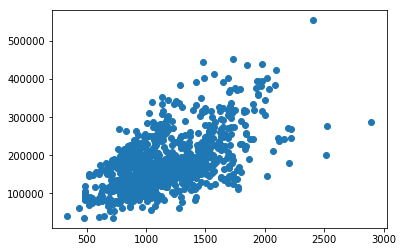

In [27]:
plt.plot(X_train["1stFlrSF"],Y_train,'o')

X = np.matrix(X_train["1stFlrSF"])
Y = np.matrix(Y_train)

print("X Shape",X.shape)
print("Y Shape",Y.shape)

We need to reshape these vectors into column vectors. When using reshape, you're always constrained by the fact that the new matrix shape needs to be compatible with the old shape. Practically, that means we can let Python figure out one dimension for us. You specify the dependent dimension by -1. For example,

`DataFrame.reshape(-1,1)` return a vector with 1 row and however many columns are required to match the original shape. 

In [29]:
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

Now, we add a column of 1's for the affine term

In [30]:
Xa = np.append(np.ones(X.shape),X,1)
Xa

matrix([[1.000e+00, 1.337e+03],
        [1.000e+00, 1.588e+03],
        [1.000e+00, 1.632e+03],
        ...,
        [1.000e+00, 1.032e+03],
        [1.000e+00, 8.400e+02],
        [1.000e+00, 9.980e+02]])

And compute beta.

In [35]:
betas = (Xa.T*Xa).I*Xa.T*Y
betas

matrix([[40571.17861927],
        [  117.9803814 ]])

We now plot the data against the fit line.

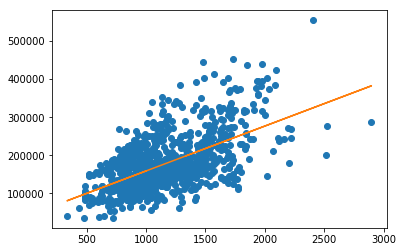

In [37]:
plt.plot(X,Y,'o')
plt.plot(X,Xa*betas)

Lets check how we did on our test set, both with a graph and numerically. Graphically, we can just plot the regression line again the test data scatter plot. We can evaluate the model numerically but computing the residual sum squared
$$
RSS(\beta) = \sum_{i=1}^N (y_i - x_i^T\beta)^2\,,
$$
the root mean square
$$
RMS(\beta) = \left(\frac{1}{N}(y_i - x_i^T\beta)^2\right)^{\frac12}\,,
$$
and the $r^2$ value
$$
r^2 = 1 - \frac{RSS(\beta)}{\sum_{i=1}^N (y_i - E[y])^2}\,.
$$

Lets set up the matrices for the test data.

Now lets use sci-kit learns built in regression function. We import `LinearRegression` from `sklearn.linear_model`, the toolkit of linear models in sci-kit learn. We then set up a linear regression object using

`lr = LinearRegression()`

An object like a linear regression object is a structure like a dataframe. It stores data, but also has a series of utility function associated with it. It is a self contained machine that we can put data into, turn a crank (by calling functions) and have it process and return that data. In this case, it takes in training data and fits a linear regressor to it. We can then ask it return the parameters of that regressor with 

* `lr.coef_` Returns the slope coefficients of regression $\beta_1,\ldots, \beta_p$.
* `lr.intercept_` Returns the intercept of regression $\beta_0$.
* `lr.score(X_data,Y_data)` Returns the $r^2$ score on `X_data` and `Y_data`.

Note, that `LinearRegression` wants the data in the form we've been using in class: the $X$ data should be a $N$ by $p$ matrix of data points and the $y$ data should be a $N$ by 1 column vector. 

In [39]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,Y)
lr.coef_

array([[117.9803814]])

#### Regression with statsmodels.api

Although in this class we will be focusing on sci-kit learn, there's another important statistics library to be aware of, statsmodels.api. For regression in particular, statsmodels.api is just a much better tool, performing all of the statistical analysis you would like. The only caveat is that stats model doesn't naturally fit to a constant term, so we must again add a column of 1's. But statsmodels.api has a function to preform that task.

* `sm.OLS(Y_Data, X_data)` OLS returns an ordinary least squares object which can then be fit with `ols.fit()`. The fit object returned by `ols.fit()` has a robust `.summary()` method that gives all us rich and detailed information about the regression fit.

Note: in addition to fitting, OLS has functions to deal with missing values and built in ridge and lasso regression functions. 

In [43]:
import statsmodels.api as sm
ols = sm.OLS(Y, Xa)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     550.2
Date:                Fri, 08 Feb 2019   Prob (F-statistic):           2.92e-97
Time:                        18:34:15   Log-Likelihood:                -12363.
No. Observations:                1000   AIC:                         2.473e+04
Df Residuals:                     998   BIC:                         2.474e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.057e+04   5989.146      6.774      0.000    2.88e+04    5.23e+04
x1           117.9804      5.030     23.457      0.000     108.110     127.850
==============================================================================
Omnibus:                      101.723   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.619
Skew:                           0.774   Prob(JB):                     1.77e-31
Kurtosis:                       4.001   Cond. No.                     3.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multilinear Regression: Cleaning Data

It actually often takes less computational time to compute a linear regression than it does to plot it. We want to fit the set of training data with all the numerical features to the sale price, but before we do we have to deal with those `NaN` values. For example, if we just try to compute the linear regression now it will return an error. 

Now, lets try to train against all of `X_train` and `Y_train` using sci-kit learn.

In [46]:
lr = LinearRegression()
#lr.fit(X_train,Y_train)
X_train

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
81,82,32.0,4500,6,5,1998,1998,443.0,1201,0,...,405,0,199,0,0,0,0,0,3,2006
1330,1331,85.0,10000,8,5,2006,2006,410.0,0,0,...,825,144,45,0,0,0,0,0,12,2007
943,944,100.0,25000,5,4,1967,1967,0.0,0,0,...,576,0,0,0,0,0,0,0,6,2007
1268,1269,NaN,14100,8,9,1935,1997,632.0,192,0,...,1014,314,12,0,0,0,0,0,5,2008
184,185,92.0,7438,5,8,1908,1991,0.0,0,0,...,576,104,0,0,0,0,0,0,6,2006
792,793,92.0,9920,7,5,1996,1997,0.0,862,0,...,455,180,130,0,0,0,0,0,6,2007
111,112,NaN,7750,7,5,2000,2000,0.0,250,0,...,400,180,0,0,0,0,0,0,4,2010
1412,1413,60.0,7200,4,5,1949,1950,0.0,0,0,...,420,0,0,0,0,0,0,0,6,2009
316,317,94.0,13005,7,7,1980,1980,278.0,692,0,...,484,288,195,0,0,0,0,0,8,2009
1391,1392,65.0,8944,5,5,1967,1967,0.0,0,0,...,792,0,152,0,0,0,0,0,4,2009


Fixing missing values is fiddly, and should be done with care. Whatever choice you make will effect your fit, and as a result will effect your accuracy. In general, data cleaning is the usually more than half the battle. 

To find the `NaN` values, we will use the `DataFrame.isnull().sum()` to return all of the null values, and them sum them along columns. 

In [47]:
data.isnull().sum()

Id                 0
LotFrontage      258
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       79
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

We find that __LotFrontage__, __MasVnrArea__, and __GarageYrBlt__ are the only numerical features with null values. Lets take a look at each of these values individually. After we make a choice for each variable, we will use

* `DataFrame.fillna(Value, inplace=True)` fills all of the `NaN` values in an array with the contents of `Value`. 

__MasVnrArea__ is "Masonry veneer area in square feet". Dumping the data we find a lot of zero values, so its probably safe to assume that 8 values can be set to 0 or the median value. 

In [51]:
X_train["MasVnrArea"]
data["MasVnrArea"].fillna(0,inplace=True)
data["MasVnrArea"].isnull().sum()

0

For __GarageYrBlt__, a value of `NaN` probably means there's no garage. Lets check just to make sure by looking at the __GarageArea__ variable for every `NaN` value.

In [55]:
data["GarageYrBlt"].fillna(0,inplace=True)

Finally, for __LotFrontage__ we assume that almost every lot has some frontage road so we don't want to set this to 0. There are more sophisticated solutions, but the simplest is just to find the median value and set the null values to it. 

In [53]:
m = np.mean(data["LotFrontage"])
data["LotFrontage"].fillna(m,inplace=True)

Finally, lets check to make sure we've elemented all missing values.

In [57]:
data.isnull().sum().sum()

0

### Cross validation and Fitting
We now reestablish our train/test split

In [121]:
Test_Size = 1000

train=data.sample(n=Test_Size,replace=False)
test=data.drop(train.index)

print("Train Shape", train.shape)
print("Test Shape", test.shape)

X_train = train.drop(columns=['SalePrice','Id'])
Y_train = train['SalePrice']

X_test = test.drop(columns=['SalePrice','Id'])
Y_test = test['SalePrice']

Train Shape (1000, 37)
Test Shape (436, 37)


And train the data using statsmodels.api. Remember that we have to add a column to `X_train` to account for the constant term. Luckily, statsmodels has built in function for that `sm.add_constant(X_data)`

In [78]:
ols = sm.OLS(Y_train, sm.add_constant(X_train))
ols_results = ols.fit()
ols_results.summary()

Y_test_hat = ols_results.predict(sm.add_constant(X_test))

Rs(Y_test_hat,Y_test)

matrix([[0.86425658]])

Now we want to score this model on test data. Unfortunately statsmodels.api doesn't have a built in test function, but we can use our own pretty easily. 

In [71]:
def RSS(y,Y):
    y = np.matrix(y).reshape(-1,1)
    Y = np.matrix(Y).reshape(-1,1)
    
    return (y-Y).T*(y-Y)

def RMS(y,Y):    
    return np.sqrt(RSS(y,Y))/len(y)

def Rs(y,Y): 
    y = np.matrix(y).reshape(-1,1)
    Y = np.matrix(Y).reshape(-1,1)
    
    return 1 - RSS(y,Y)/((Y - np.mean(Y)).T*(Y - Y.mean()))

## Ridge Regression and Lasso Regression

Now that we have a baseline, we try out our new methods. We will actually be look at ridge regression and lasso regression first, since they are actually implemented and so easier to code in. 

An `statsmodel.api.ols` object has a regularized regression fit function `ols.fit_regualrized()` that implements both lasso and ridge regression. In fact, it minimizes the loss function

$$
\textbf{Loss}(\beta) = \frac{1}{2n}\textbf{RSS} + \alpha\left(\frac{(1-\lambda)}{2}\sum_i \beta_i^2 + \lambda\sum_i|\beta_i|\right)
$$

This linear combination of loss functions is known as __elastic net regression__. For a little demo of the interpolation between the bounded regions for the variables take a look at this Desmos applet:

https://www.desmos.com/calculator/a4a6qgitr7

The `ols.fit_regualrized()` takes the following form, where $\lambda$ is `L1_wt`:

* `OLS.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None)` Here, `alpha` is the overall weight $\alpha$ and `L1_wt` is the coefficient of the $L_1$ norm. 

## Ridge Regression

First, lets compute the ridge regression. Note that not all of the functionality has been added to statsmodels.api's OLS class yet. In particular, summary doesn't work. But we can still compute $r^2$ values on the test set using the functions we defined above. Pick a value at random, let's compute with $\alpha = 1$

In [82]:
ols = sm.OLS(Y_train, sm.add_constant(X_train))
ols_results = ols.fit_regularized(alpha=.04,L1_wt=0)
Y_test_hat = ols_results.predict(sm.add_constant(X_test))

Rs(Y_test_hat,Y_test)

matrix([[0.8627254]])

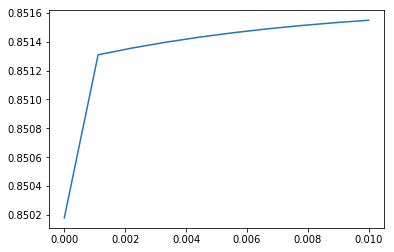

In [122]:
alphas = np.linspace(0,.01,10)

rs_s = []

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_results = ols.fit_regularized(alpha=alp,L1_wt=0)
    Y_test_hat = ols_results.predict(sm.add_constant(X_test))

    rs_s = rs_s + [Rs(Y_test_hat,Y_test).A1]

plt.plot(alphas,rs_s)

We're probably already doing worse than expected. Lets predict for 50 $\alpha$ values from 0 to 1. We will save the $r^2$ value in in a list, by creating an empty list and appending each value into it. 

If we add a few lines of code to save the $\hat \beta$ values at each iteration, you can plot them again each other. Of course, the vast difference in $\hat \beta$ values we saw in the ordinary linear regression model indicates that they wont be very meaningful on the same graph (the largest are on the order of $10^6$, the smallest on the order of $10^{-1}$). 

The simplest way to overcome this, if we are just interested in the dynamics of the variables, is to normalize the largest $|\beta_i^{\alpha}|$ to 1 for each feature. This can be done by dividing by the max of the absolute value. 

No handles with labels found to put in legend.


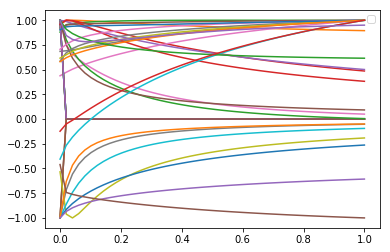

In [96]:
alphas = np.linspace(0,1,50)

rs_s = []
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_results = ols.fit_regularized(alpha=alp,L1_wt=0)
    
    Y_test_hat = ols_results.predict(sm.add_constant(X_test))
    rs_s = rs_s + [Rs(Y_test_hat,Y_test).A1]
    beta = pd.DataFrame(ols_results.params.reshape(1,-1),
                        columns=["Coeff"]+list(X_train))
    betas = betas.append(beta)

plt.plot(alphas,betas/betas.abs().max())
plt.legend()

In [90]:
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))
betas

,Coeff,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold


## Lasso Regression

To compute the Lasso regression we can recycle our code from above, but now we set `L1_wt=1`, turning off the ridge parameters and turning of the Lasso. We will also have to modify our $alpha$ values since the $\beta$ are penalized much less for being large. 

# Subset Selection:

We will implement subset selection algorithms. Before we could lean on built in libraries, but we will now have to implement the algorithms ourselves. Luckily, subset selection is a relatively straight forward idea. 

## Forward subset selection:

We will begin with forward subset selection. The idea is to greedily add variables to our fitting, starting with the best single variable predictor and adding new variables one at a time. 

We will implement a function that returns the best predictor to add to a list of preselected predictors. This function will take the form

* `best_predict(inc, X_train, Y_train)` Where `inc` is a list of predictors that we have already included.

In [115]:
def best_predict(inc, X_train,Y_train,X_test, Y_test):
    rem_pred = [p for p in X_train.columns if p not in inc]
    
    RSquared = []
    Columns = []
    for p in rem_pred:
        olst = sm.OLS(Y_train,sm.add_constant(X_train[inc+[p]]))
        olst_result = olst.fit()
        r = olst_result.predict(sm.add_constant(X_train[inc+[p]]))
#        print("Column", p, "R^2", Rs(r, Y_test))
        RSquared.append(Rs(r, Y_train))
        Columns.append(inc+[p])
    
    z = RSquared.index(max(RSquared))
    print("Max",RSquared[z])
    print("Columns",Columns[z])
    
    return([float(RSquared[z]), Columns[z]])

Max [[0.63338002]]
Columns ['OverallQual']
Max [[0.63338002]]
Columns ['OverallQual']
Max [[0.7214982]]
Columns ['OverallQual', '1stFlrSF']
Max [[0.7621351]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF']
Max [[0.79815834]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1']
Max [[0.82137085]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'YearBuilt']
Max [[0.83049492]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'YearBuilt', 'OverallCond']
Max [[0.83845066]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'YearBuilt', 'OverallCond', 'GarageArea']
Max [[0.84547753]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'YearBuilt', 'OverallCond', 'GarageArea', 'LotArea']
Max [[0.85013432]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'YearBuilt', 'OverallCond', 'GarageArea', 'LotArea', 'TotalBsmtSF']
Max [[0.85532776]]
Columns ['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'YearBuilt', 'OverallCo

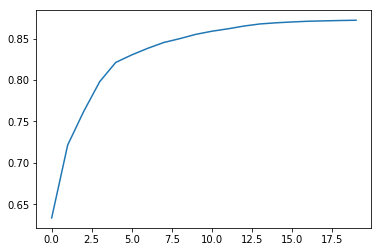

In [116]:
best_predict([], X_train,Y_train,X_test, Y_test)

varlist = []
r_list = []

for i in range(0,20):
    r,varlist = best_predict(varlist, X_train,Y_train,X_test, Y_test)
    r_list = r_list+[r]
    
plt.plot(r_list)

## (Extra) Best subset selection:

Best subset selection is impractical on large arrays of variables, but it's good to understand how it can be implemented. The code below uses itertools to iterate over all subsets of the range. Notice though that even for subsets of size 3 it really begins to chug. This naive version of best subset selection shouldn't be used for data sets with this many features. 